In [1]:
import torch 
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from pd.nn.conv import Conv

from pd.metric import amex_metric
from pd.data.loader import CustomerData, DataLoader
from pd.params import *
from pd.pred import pred_test_npy
from sklearn.model_selection import train_test_split


In [2]:
train_data = pd.read_parquet(DATADIR+"train_data.parquet")
train_labels = pd.read_csv(DATADIR+"train_labels.csv")
train_labels.set_index("customer_ID", inplace=True)


In [3]:
train_customers = train_data.customer_ID
train_count =  train_customers.value_counts()
train_c13 = train_count[train_count==13].index
train_data = train_data[train_data.customer_ID.isin(train_c13)]


In [3]:
data_cat_agg = train_data.groupby("customer_ID")[CATCOLS].agg(['count', 'last', 'nunique'])
    

In [5]:
data_cat_agg.shape

(458913, 33)

In [85]:
for c in CATCOLS:
    if c in betterTransFeatsK79:
        print(c)

D_114
D_116
D_120
D_63
D_64
D_66
D_68


In [86]:
CATCOLS

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_66',
 'D_68']

In [65]:
c = "R_13"
d = train_data["R_13"]


/var/folders/t2/_nykd9tn43dfx142nv5r8l900000gn/T/ipykernel_26043/888282133.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  slope = 2.944/(col_info13[c]["q95"] - mid_point)


In [66]:
slope

inf

In [64]:
a = ((d - col_info13["R_13"][f"mean_{lb}_{ub}"])/col_info13["R_13"][f"std_{lb}_{ub}"])

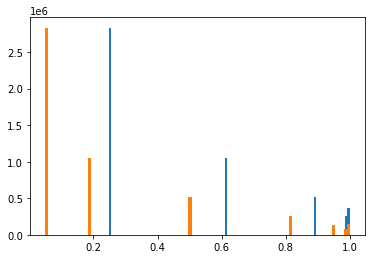

In [53]:
from scipy.stats import norm
_ = plt.hist(norm.cdf(a), bins=100)
_ = plt.hist(1/(1 + np.exp(slope*(mid_point - d))), bins=100)


In [4]:
    cols = featureCols

    if train_data is None:
        train_data = pd.read_parquet(TRAINDATA)
    if c13:
        train_customers = train_data.customer_ID
        train_count =  train_customers.value_counts()
        train_c13 = train_count[train_count==13].index
        train_data = train_data[train_data.customer_ID.isin(train_c13)]
        col_info_name = f"{col_info_name}13"

    for cat_col in CATCOLS:
        encoder = LabelEncoder()
        train_data[cat_col] = encoder.fit_transform(train_data[cat_col])
    
    col_info = {}
    for c in cols:
        col_info[c] = {}
        d = train_data[c]
        q2 = d.quantile(0.02)
        q98 = d.quantile(0.98)
        q5 = d.quantile(0.05)
        q95 = d.quantile(0.95)
        
        col_min_val = d.min()
        col_max_val = d.max()
        hist = np.histogram(d, range=[q2, q98], density=True, bins=100)
        
        col_info[c]["num_nan"] = 1 - d.dropna().shape[0]/d.shape[0]
        col_info[c]["q2"] = q2
        col_info[c]["q98"] = q98
        col_info[c]["q1"] = d.quantile(0.01)
        col_info[c]["q99"] = d.quantile(0.99)
        
        col_info[c]["min"] = col_min_val
        col_info[c]["max"] = col_max_val
        col_info[c]["mean"] = d.mean()
        col_info[c]["median"] = d.quantile(0.5)
        col_info[c]["hist"] = hist
        col_info[c]["max_prob_mass"] = hist[0].max()
        col_info[c]["num_nonzero_bins"] = np.count_nonzero(hist[0])
    

NameError: name 'c13' is not defined

In [20]:
nzs = []
dist_col_27 = []
for c in col_info.keys():
    nz = np.count_nonzero(col_info[c]["hist"][0])
    nzs.append(nz)
    if nz < 27:
        dist_col_27.append(c)

## Train with Conv Model

## Train with aggregation over the features

### Mean aggregation

In [34]:
from bes.nn.es_module import ESModule
import torch 
import torch.nn as nn
import torch.nn.functional as F

class MLP(ESModule):

    def __init__(self, input_dim, hidden_dim=128,):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.nf1 = nn.LayerNorm([hidden_dim])
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf2 = nn.LayerNorm([hidden_dim])
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf3 = nn.LayerNorm([hidden_dim])
        self.fc4 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf4 = nn.LayerNorm([hidden_dim])
        self.fc5 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf5 = nn.LayerNorm([hidden_dim])
        
        self.fcout = nn.Linear(in_features=hidden_dim, out_features=1)
    
    def forward(self, h, return_featues=False):
        h = F.selu(self.fc1(h))
        r = self.nf1(h)
        h = F.selu(self.fc2(r))
        h = self.nf2(h)
        h = F.selu(self.fc3(h))
        r = self.nf3(h+r)
        h = F.selu(self.fc4(r))
        h = self.nf4(h)
        h = F.selu(self.fc5(h))
        h = self.nf5(h+r)
        if return_featues:
            return torch.sigmoid(self.fcout(h)), h
        
        return torch.sigmoid(self.fcout(h))



In [42]:
# take the sum of the of the data and normalize by the max vals 
X = train_data.sum(axis=1) 
for idx, c in enumerate(dist_col_27):
    X[:, idx] = X[:, idx]/col_info[c]["max"]

X = X/X.max(axis=0)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=1/9, random_state=0, shuffle=True)
validation_data = (X_test, y_test)


In [60]:
train_dataset = CustomerData(X_train, train_labels=y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)


In [61]:
model_name = "mlp_col27_sum"
model = MLP(input_dim=91)
model = train_torch_model(model, train_loader, num_epochs=100, validation_data=validation_data, 
                            output_model_name=model_name)


0, BCE loss: 0.660, amex train: -0.043, val 0.000
0, BCE loss: 0.618, amex train: 0.281, val 0.000
0, BCE loss: 0.586, amex train: 0.452, val 0.000
0, BCE loss: 0.493, amex train: 0.490, val 0.000
0, BCE loss: 0.449, amex train: 0.490, val 0.000
0, BCE loss: 0.468, amex train: 0.505, val 0.000
0, BCE loss: 0.453, amex train: 0.525, val 0.000
0, BCE loss: 0.414, amex train: 0.529, val 0.000
0, BCE loss: 0.385, amex train: 0.536, val 0.000
0, BCE loss: 0.383, amex train: 0.567, val 0.000
0, BCE loss: 0.388, amex train: 0.553, val 0.000
0, BCE loss: 0.377, amex train: 0.570, val 0.000
0, BCE loss: 0.348, amex train: 0.588, val 0.000
0, BCE loss: 0.355, amex train: 0.580, val 0.000
0, BCE loss: 0.361, amex train: 0.585, val 0.000
0, BCE loss: 0.373, amex train: 0.590, val 0.000
0, BCE loss: 0.348, amex train: 0.607, val 0.000
0, BCE loss: 0.345, amex train: 0.608, val 0.000
0, BCE loss: 0.343, amex train: 0.612, val 0.000
0, BCE loss: 0.347, amex train: 0.605, val 0.000
0, BCE loss: 0.346,

## Train a model with only c27 (extract a feature for them)

## Aggregate Model with pre-trained conv

In [64]:
pred, conv_feat =  conv(torch.as_tensor(np.load(OUTDIR+"train_data_all.npy"), dtype=torch.float32), return_featues=True)

In [13]:
3.40+11.70+13.10+1.69+6.10

35.99

In [4]:
X = np.load(OUTDIR+"agg_feat.npy")

In [5]:
train_labels = np.load(OUTDIR+"train_labels_all.npy")
    

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=1/9, random_state=0, shuffle=True)
validation_data = (X_test, y_test)

train_dataset = CustomerData(X_train, train_labels=y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

    

In [6]:
from pd.nn.train_utils import train_torch_model
from bes.nn.es_module import ESModule
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [7]:

class MLP(ESModule):

    def __init__(self, input_dim, hidden_dim=128,):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.nf1 = nn.LayerNorm([hidden_dim])
        
        self.fcout = nn.Linear(in_features=hidden_dim, out_features=1)
    
    def forward(self, h, return_featues=False):
        h = F.selu(self.fc1(h))
        h = self.nf1(h)
        if return_featues:
            return torch.sigmoid(self.fcout(h)), h
        
        return torch.sigmoid(self.fcout(h))

In [8]:
class MLP(ESModule):

    def __init__(self, input_dim, hidden_dim=128,):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.nf1 = nn.LayerNorm([hidden_dim])
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf2 = nn.LayerNorm([hidden_dim])
        self.fc3 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf3 = nn.LayerNorm([hidden_dim])
        self.fc4 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf4 = nn.LayerNorm([hidden_dim])
        self.fc5 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.nf5 = nn.LayerNorm([hidden_dim])
        
        self.fcout = nn.Linear(in_features=hidden_dim, out_features=1)
    
    def forward(self, h, return_featues=False):
        h = F.selu(self.fc1(h))
        r = self.nf1(h)
        h = F.selu(self.fc2(r))
        h = self.nf2(h)
        h = F.selu(self.fc3(h))
        r = self.nf3(h+r)
        h = F.selu(self.fc4(r))
        h = self.nf4(h)
        h = F.selu(self.fc5(h))
        h = self.nf5(h+r)
        if return_featues:
            return torch.sigmoid(self.fcout(h)), h
        
        return torch.sigmoid(self.fcout(h))


In [9]:
model = MLP(input_dim=X.shape[-1])
optimizer = torch.optim.Adam(model.parameters(),)
criterion = torch.nn.BCELoss()


for epoch in range(50): 
    for idx, (feat, clabel) in enumerate(train_loader):
        if len(feat.shape) == 4:  ## Reduce shape if its coming from a ratio version of the loader
            feat = feat.squeeze(dim=0)
            clabel = clabel.squeeze(dim=0)

        pred = model(feat)
        #weight = clabel.clone()
        #weight[weight==0] = 4
        #criterion.weight = weight
        loss = criterion(pred, clabel)
        
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model_metric = amex_metric(clabel.detach().numpy(), pred.detach().numpy())
        val_metrix = 0
        if model_metric > 0.78:
            X_test, y_test = validation_data
            val_features = torch.as_tensor(X_test, dtype=torch.float32)
            val_pred = model(val_features)
            val_metrix = amex_metric(y_test, val_pred.detach().numpy())

        log_message = f"{epoch}, BCE loss: {loss.item():.3f}, amex train: {model_metric:.3f}, val {val_metrix:.3f}"
        print(log_message)    

0, BCE loss: 0.887, amex train: -0.070, val 0.000
0, BCE loss: 0.457, amex train: 0.719, val 0.000
0, BCE loss: 0.343, amex train: 0.772, val 0.000
0, BCE loss: 0.239, amex train: 0.791, val 0.772
0, BCE loss: 0.262, amex train: 0.791, val 0.772
0, BCE loss: 0.294, amex train: 0.772, val 0.000
0, BCE loss: 0.259, amex train: 0.785, val 0.775
0, BCE loss: 0.233, amex train: 0.783, val 0.774
0, BCE loss: 0.225, amex train: 0.789, val 0.774
0, BCE loss: 0.251, amex train: 0.769, val 0.000
0, BCE loss: 0.267, amex train: 0.774, val 0.000
0, BCE loss: 0.252, amex train: 0.781, val 0.776
0, BCE loss: 0.227, amex train: 0.793, val 0.776
0, BCE loss: 0.228, amex train: 0.781, val 0.777
0, BCE loss: 0.221, amex train: 0.801, val 0.777
0, BCE loss: 0.236, amex train: 0.784, val 0.777
0, BCE loss: 0.237, amex train: 0.791, val 0.777
0, BCE loss: 0.235, amex train: 0.778, val 0.000
0, BCE loss: 0.225, amex train: 0.792, val 0.777
0, BCE loss: 0.223, amex train: 0.786, val 0.777
0, BCE loss: 0.224,

In [10]:
import lightgbm as lgb


In [ ]:
val_pred = model.predict(X_test)
amex_metric(y_test, val_pred)
        

# Train with Given preds

In [1]:
import os
import gc
import tempfile
import click
import json
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import Sampler, BatchSampler
from pd.metric import amex_metric
from pd.utils import write_log
from pd.nn.conv import ConvPred
from pd.utils import merge_with_pred, get_torch_agg_data, get_customers_data_indices, get_pred_data
from pd.params import *


In [7]:
train_data = np.load(OUTDIR+"train_logistic_raw_all_mean_q5_q95_q5_q95_data.npy")
train_labels = np.load(OUTDIR+"train_logistic_raw_all_mean_q5_q95_q5_q95_labels.npy")
    
pred_data = get_pred_data(type="train", id_dir='train_logistic_raw_all_mean_q5_q95_q5_q95_id.json')

model_name = f"conv_pred{agg}"
indices = get_customers_data_indices(num_data_points=np.arange(14), id_dir='train_logistic_raw_all_mean_q5_q95_q5_q95_id.json')


# Ensemble Analysis 

In [1]:
#%%
import os
import click
import functools
import torch
import numpy as np
import pandas as pd 
import torch.nn as nn
import torch.nn.functional as F
from bes.nn.es_module import ESModule
import ray
import tempfile
import json
from sklearn.model_selection import train_test_split

from bes.es import CMAES, BES
from pd.nn.mlp import Linear
from pd.params import *
#from pd.data.loader import load_npy_data as load_data
from pd.metric import amex_metric
from pd.nn.recall_models import MLP, MLPAtt
from torch.utils.data import Dataset, DataLoader


In [9]:
train_data = pd.read_csv(PREDDIR+"train_pred.csv", index_col=0)
train_labels = train_data["target"].values
train_data["STD"] = train_data.apply(np.std, axis=1)
train_data["STD"] = train_data["STD"]/train_data["STD"].max()
#train_data = train_data.drop("target", axis=1)
cols  = [col for col in train_data.columns if col != "target"]
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=1/9, random_state=0, shuffle=True)


In [10]:
input_dim = X_train.shape[1] - 1
model = MLPAtt(input_dim)


In [11]:
model.num_params

5634

In [13]:
for i in [2125, 2126, 2127, 2128]:
    params = np.load(OUTDIR+f"best_iteration_{i}.npy")
    model.set_model_params(params)
    val_features = torch.from_numpy(X_test[cols].values).float()
    val_pred = model(val_features)
    val_metrix = amex_metric(y_test, val_pred.detach().numpy(), return_components=True)
    print("The val ", val_metrix)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\20204069\\Desktop\\Kaggle\\pd\\data\\out\\best_iteration_2125.npy'

In [29]:
val_pred

tensor([[0.2431],
        [0.2265],
        [0.2440],
        ...,
        [0.2411],
        [0.2265],
        [0.2398]])

In [37]:
x.sort_values(by=["Att", "target"], ascending=False)

,target,xgbm13_p0_agg4,catb13_agg4,xgbm_p0_agg4,catb_agg4,xgbm13_p0_agg1,catb13_agg1,xgbm_p0_agg1,catb_agg1,xgbm13_p0_agg2,...,catb_agg2,xgbm13_p0_agg0,catb13_agg0,xgbm_p0_agg0,catb_agg0,xgbmv213_p0_agg0,xgbmv2_p0_agg0,conv_pred0,STD,Att
customer_ID,,,,,,,,,,,,,,,,,,,,,
ebf01d675f1ffad735f18cba02fcb9e6ca89a1633f5716457246da57755b1f78,0,0.309720,0.296176,0.307184,0.355913,0.215021,0.306461,0.233854,0.314976,0.234227,...,0.315471,0.629669,0.618208,0.611849,0.663287,0.648590,0.652470,0.062163,0.570986,0.320494
87ddf1ad5bd3e1d038f5d7e640c647a416e4944014768f94395425a94297652a,0,0.205436,0.238079,0.209533,0.245606,0.217923,0.241338,0.245820,0.191445,0.225875,...,0.257072,0.627670,0.597561,0.698448,0.640387,0.670146,0.636105,0.226823,0.593282,0.310911
57bb71d548b10bed45501a0ec86e8ad61d38335ae1f69b5b5dd64243fa67a5a0,1,0.084283,0.070323,0.440324,0.474457,0.041680,0.029544,0.265599,0.261648,0.048897,...,0.385013,0.073103,0.089830,0.577796,0.523989,0.060392,0.569014,0.208142,0.734500,0.271766
bcecd31e6a09846f509bf1006e080db314326f6dcd749c9c15df5147df9aeafb,1,0.016243,0.020338,0.022005,0.023244,0.013838,0.014074,0.032765,0.042311,0.014107,...,0.041445,0.010715,0.015951,0.015043,0.020866,0.008034,0.015728,0.042841,0.619363,0.265544
fd56a8c99d464dd82dbae558ea4b1d77eab030eee60e20a6e86b88f7d6a0908a,1,0.011911,0.028595,0.013458,0.034085,0.014426,0.028953,0.019422,0.030693,0.012546,...,0.031547,0.011929,0.018085,0.015160,0.021376,0.013789,0.016530,0.072529,0.619253,0.265508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0489c5ce0cc83266b048f70bb8f20295b398d6487c184fe2f1aa8fc9ac0bfa04,0,0.110715,0.092340,0.139149,0.122975,0.062369,0.072801,0.097148,0.096535,0.077184,...,0.098265,0.152507,0.104120,0.163868,0.146115,0.175431,0.155093,0.156723,0.122086,0.226505
239028a5c0df09621fcec9b6ddd457aa2d18b21fbf3be7749258882a57f4b96f,0,0.004550,0.002573,0.005790,0.003668,0.003580,0.003271,0.005776,0.003363,0.006581,...,0.004368,0.007277,0.003766,0.006623,0.004221,0.004627,0.002946,0.007259,0.005164,0.226505
3d674abe8cb89890c103748577ed1c7d087e952658fe17411b3f0e02a3066cea,0,0.028969,0.054836,0.031787,0.043711,0.034292,0.085556,0.048540,0.052052,0.041087,...,0.061763,0.040065,0.050595,0.045576,0.048228,0.038002,0.039586,0.071938,0.049605,0.226505


In [11]:
train_data = pd.read_csv(PREDDIR+"train_pred.csv", index_col=0)
test_data = pd.read_csv(PREDDIR+"test_pred.csv", index_col=0)


In [12]:
len(train_data)

458913

In [14]:
train_data

,target,xgbm13_p0_agg4,catb13_agg4,xgbm_p0_agg4,catb_agg4,xgbm13_p0_agg1,catb13_agg1,xgbm_p0_agg1,catb_agg1,xgbm13_p0_agg2,...,catb13_agg0,xgbm_p0_agg0,catb_agg0,xgbmv213_p0_agg0,xgbmv2_p0_agg0,conv_pred0,K7977_xgb_42,K7977_xgb_52,K7977_xgb_62,K7977_xgb_82
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,0.001161,0.000529,0.000842,0.000445,0.001045,0.000503,0.000937,0.000387,0.000908,...,0.000383,0.001079,0.000288,0.000329,0.000353,0.280048,0.000257,0.000279,0.000279,0.000279
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0,0.001499,0.000868,0.001189,0.000648,0.001601,0.001390,0.001547,0.001215,0.001622,...,0.001289,0.001231,0.001021,0.001514,0.001200,0.280590,0.001341,0.001328,0.001328,0.001328
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0,0.001104,0.001431,0.001254,0.001210,0.001626,0.001561,0.001255,0.001549,0.001448,...,0.001812,0.002137,0.001791,0.001509,0.002012,0.280590,0.001228,0.001145,0.001145,0.001145
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0,0.018017,0.009783,0.016114,0.009630,0.012393,0.005425,0.015091,0.007225,0.011902,...,0.006965,0.020323,0.008674,0.014359,0.014149,0.280934,0.006640,0.008457,0.008457,0.008457
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0,0.002971,0.003396,0.002746,0.003013,0.001842,0.003420,0.001918,0.002653,0.002224,...,0.004677,0.003453,0.004487,0.003531,0.003796,0.280934,0.002449,0.002614,0.002614,0.002614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0,0.002730,0.004286,0.002113,0.003219,0.003145,0.003823,0.003080,0.005093,0.002441,...,0.005103,0.002280,0.004329,0.002480,0.002420,0.280837,0.002978,0.003718,0.003718,0.003718
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0,0.030506,0.028569,0.020954,0.026186,0.016143,0.023527,0.015302,0.021109,0.022114,...,0.025614,0.024308,0.022978,0.024616,0.028101,0.280934,0.027376,0.023917,0.023917,0.023917
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0,0.001327,0.001241,0.002094,0.001248,0.002010,0.001161,0.002095,0.001167,0.002004,...,0.000895,0.001551,0.000821,0.001009,0.000888,0.280837,0.002134,0.002547,0.002547,0.002547


In [6]:
train_data.columns

Index(['target', 'xgbm13_p0_agg4', 'catb13_agg4', 'xgbm_p0_agg4', 'catb_agg4',
       'xgbm13_p0_agg1', 'catb13_agg1', 'xgbm_p0_agg1', 'catb_agg1',
       'xgbm13_p0_agg2', 'catb13_agg2', 'xgbm_p0_agg2', 'catb_agg2',
       'xgbm13_p0_agg0', 'catb13_agg0', 'xgbm_p0_agg0', 'catb_agg0',
       'xgbmv213_p0_agg0', 'xgbmv2_p0_agg0', 'conv_pred0'],
      dtype='object')

In [2]:
from pd.params import *
import pandas as pd 
train_data = pd.read_parquet(TRAINDATA)

In [12]:
d = train_data.groupby("customer_ID")[bestCols].agg(['mean', 'std', 'min', 'max', "first", 'last'])

In [11]:
df = pd.read_csv(os.path.join(PREDDIR, "train_pred.csv"), index_col=0)


In [14]:
df = df.merge(d, how="left", on="customer_ID")

c:\Users\20204069\Anaconda3\envs\p8\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,target,xgbm13_p0_agg4,catb13_agg4,xgbm_p0_agg4,catb_agg4,xgbm13_p0_agg1,catb13_agg1,xgbm_p0_agg1,catb_agg1,xgbm13_p0_agg2,...,"(B_2, min)","(B_2, max)","(B_2, first)","(B_2, last)","(B_9, mean)","(B_9, std)","(B_9, min)","(B_9, max)","(B_9, first)","(B_9, last)"
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0,0.001161,0.000529,0.000842,0.000445,0.001045,0.000503,0.000937,0.000387,0.000908,...,1.000242,1.009672,1.006838,1.007647,0.006220,0.003180,0.000519,0.009535,0.008207,0.009535
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0,0.001499,0.000868,0.001189,0.000648,0.001601,0.001390,0.001547,0.001215,0.001622,...,0.819772,1.008534,1.002647,1.004028,0.010298,0.011024,0.001722,0.045093,0.007561,0.012926
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0,0.001104,0.001431,0.001254,0.001210,0.001626,0.001561,0.001255,0.001549,0.001448,...,0.810796,0.819987,0.810796,0.812649,0.004730,0.003302,0.000422,0.009521,0.003663,0.009392
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0,0.018017,0.009783,0.016114,0.009630,0.012393,0.005425,0.015091,0.007225,0.011902,...,0.812053,1.009999,0.812053,1.006183,0.052241,0.053342,0.001702,0.176352,0.026897,0.020526
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0,0.002971,0.003396,0.002746,0.003013,0.001842,0.003420,0.001918,0.002653,0.002224,...,0.810670,0.819947,0.818691,0.815746,0.006685,0.002242,0.002925,0.009847,0.005475,0.004027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0,0.002730,0.004286,0.002113,0.003219,0.003145,0.003823,0.003080,0.005093,0.002441,...,1.000524,1.009987,1.000690,1.009866,0.138467,0.085967,0.013571,0.299308,0.013571,0.170243
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0,0.030506,0.028569,0.020954,0.026186,0.016143,0.023527,0.015302,0.021109,0.022114,...,0.030446,0.055656,0.030639,0.055656,0.186676,0.028611,0.143207,0.230870,0.224073,0.143207
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0,0.001327,0.001241,0.002094,0.001248,0.002010,0.001161,0.002095,0.001167,0.002004,...,0.004150,1.009931,1.008807,1.007023,0.080004,0.047993,0.020363,0.193388,0.111800,0.046456


In [19]:
cols = ["catb_agg1", "catb_agg2", "K7977_xgb_52", "K7977_xgb_62", "K7977_xgb_82","K7977_catb_52" ,"K7977_focal_52" ,
        "K7977_catb_62", "K7977_focal_62", "K7977_catb_82", "K7977_focal_82", "K7977_focal_xgb_42", "K7977_focal_xgb_52", "K7977_focal_xgb_62"]



['catb_agg1',
 'catb_agg2',
 'K7977_xgb_52',
 'K7977_xgb_62',
 'K7977_xgb_82',
 'K7977_catb_52',
 'K7977_focal_52',
 'K7977_catb_62',
 'K7977_focal_62',
 'K7977_catb_82',
 'K7977_focal_82',
 'K7977_focal_xgb_42',
 'K7977_focal_xgb_52',
 'K7977_focal_xgb_62',
 ('P_2', 'mean'),
 ('P_2', 'std'),
 ('P_2', 'min'),
 ('P_2', 'max'),
 ('P_2', 'first'),
 ('P_2', 'last'),
 ('D_48', 'mean'),
 ('D_48', 'std'),
 ('D_48', 'min'),
 ('D_48', 'max'),
 ('D_48', 'first'),
 ('D_48', 'last'),
 ('R_1', 'mean'),
 ('R_1', 'std'),
 ('R_1', 'min'),
 ('R_1', 'max'),
 ('R_1', 'first'),
 ('R_1', 'last'),
 ('D_44', 'mean'),
 ('D_44', 'std'),
 ('D_44', 'min'),
 ('D_44', 'max'),
 ('D_44', 'first'),
 ('D_44', 'last'),
 ('B_2', 'mean'),
 ('B_2', 'std'),
 ('B_2', 'min'),
 ('B_2', 'max'),
 ('B_2', 'first'),
 ('B_2', 'last'),
 ('B_9', 'mean'),
 ('B_9', 'std'),
 ('B_9', 'min'),
 ('B_9', 'max'),
 ('B_9', 'first'),
 ('B_9', 'last')]

In [17]:
d.columns.to_list()

[('P_2', 'mean'),
 ('P_2', 'std'),
 ('P_2', 'min'),
 ('P_2', 'max'),
 ('P_2', 'first'),
 ('P_2', 'last'),
 ('D_48', 'mean'),
 ('D_48', 'std'),
 ('D_48', 'min'),
 ('D_48', 'max'),
 ('D_48', 'first'),
 ('D_48', 'last'),
 ('R_1', 'mean'),
 ('R_1', 'std'),
 ('R_1', 'min'),
 ('R_1', 'max'),
 ('R_1', 'first'),
 ('R_1', 'last'),
 ('D_44', 'mean'),
 ('D_44', 'std'),
 ('D_44', 'min'),
 ('D_44', 'max'),
 ('D_44', 'first'),
 ('D_44', 'last'),
 ('B_2', 'mean'),
 ('B_2', 'std'),
 ('B_2', 'min'),
 ('B_2', 'max'),
 ('B_2', 'first'),
 ('B_2', 'last'),
 ('B_9', 'mean'),
 ('B_9', 'std'),
 ('B_9', 'min'),
 ('B_9', 'max'),
 ('B_9', 'first'),
 ('B_9', 'last')]

customer_ID
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    0.933824
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5    0.899820
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    0.878454
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc    0.598969
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    0.891679
                                                                      ...   
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7    0.848750
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286    0.859327
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6    0.786838
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461    0.804454
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681    0.983617
Name: (P_2, mean), Length: 458913, dtype: float32